In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz
!tar -xvzf annotations.tar.gz

In [13]:
import os
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive

In [14]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
folder = "/content/annotations/trimaps/"
for filename in os.listdir(folder):
  if filename.startswith("._"):
    os.remove(os.path.join(folder, filename))

remaining = [f for f in os.listdir(folder) if f.startswith(".-")]
if len(remaining) == 0:
  print("all files was removed")
else:
  print(f"{len(remaining)} files not yet remove")

all files was removed


In [16]:
print(os.listdir("/content/annotations"))

['trimaps', 'test.txt', 'list.txt', 'README', '._trimaps', 'xmls', 'trainval.txt']


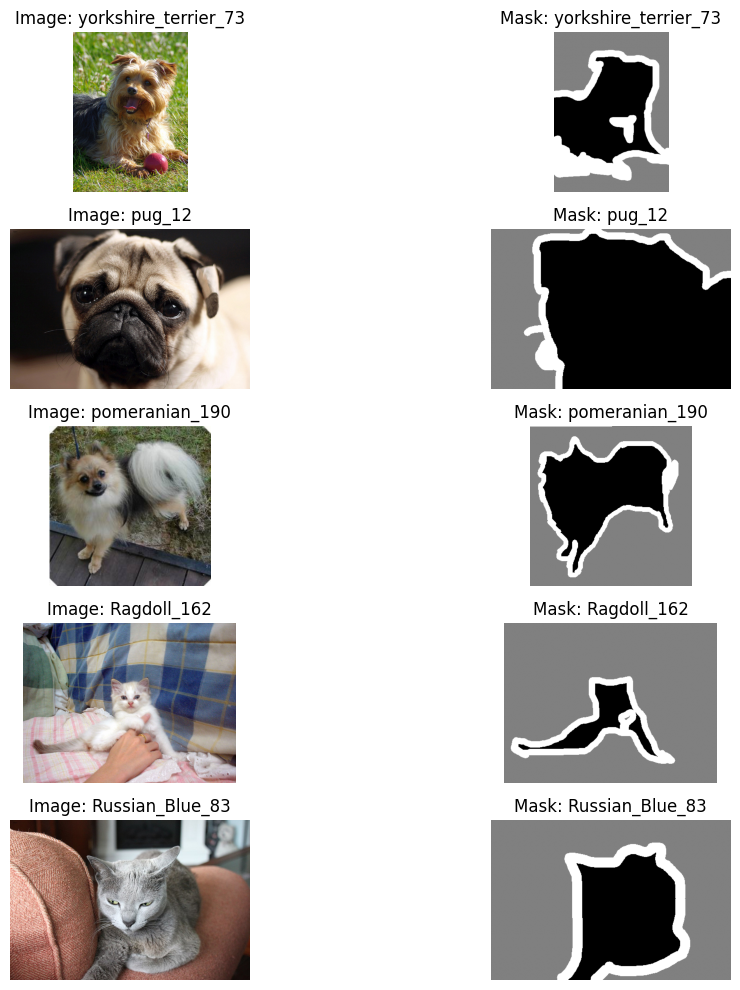

In [17]:
image_dir = "/content/images"
mask_dir = "/content/annotations/trimaps"

sample_names = ["yorkshire_terrier_73", "pug_12", "pomeranian_190", "Ragdoll_162", "Russian_Blue_83"]

plt.figure(figsize=(12,10))
for i, name in enumerate(sample_names):
  img_path = os.path.join(image_dir, f"{name}.jpg")
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  mask_path = os.path.join(mask_dir, f"{name}.png")
  mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

  plt.subplot(len(sample_names), 2, 2*i+1)
  plt.imshow(image)
  plt.title(f"Image: {name}")
  plt.axis("off")

  plt.subplot(len(sample_names), 2, 2*i+2)
  plt.imshow(mask, cmap="gray")
  plt.title(f"Mask: {name}")
  plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
image_paths = []
mask_paths = []

for fname in os.listdir(image_dir):
  if fname.endswith(".jpg"):
    name = fname[:-4]

    img_path = os.path.join(image_dir, fname)
    mask_path = os.path.join(mask_dir, f"{name}.png")
    if os.path.exists(mask_path):
      image_paths.append(img_path)
      mask_paths.append(mask_path)

print(f"number of sample: {len(image_paths)}")

number of sample: 7390


In [19]:
def load_image_and_mask(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [224, 224], method='nearest')
    mask = tf.squeeze(mask, axis=-1)
    mask = mask - 1
    mask = tf.cast(mask, tf.int32)

    return img, mask

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)


In [21]:
import tensorflow as tf

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(f)
    return f, p

def decoder_block(x, skip, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(224, 224, 3), num_classes=3):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(d4)

    return tf.keras.Model(inputs, outputs)

model = build_unet()
def iou_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)

    intersection = tf.reduce_sum(tf.cast(y_true == y_pred, tf.float32))
    union = tf.cast(tf.size(y_true), tf.float32)

    return intersection / union


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), iou_metric]
)
model.summary()

In [22]:
total_size = len(image_paths)
train_size = int(0.8 * total_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
checkpoint_cb = ModelCheckpoint(
    "/content/drive/MyDrive/best_unet_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[checkpoint_cb, early_stop_cb]
)

Epoch 30/30 462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - iou_metric: 0.9578 - loss: 0.0990 - sparse_categorical_accuracy: 0.9578
WARNING:absl:You are saving your model as an HDF5 file via model.save() or keras.saving.save_model(model). This file format is considered legacy. We recommend using instead the native Keras format, e.g. model.save('my_model.keras') or keras.saving.save_model(model, 'my_model.keras').
462/462 ━━━━━━━━━━━━━━━━━━━━ 378s 812ms/step - iou_metric: 0.9578 - loss: 0.0990 - sparse_categorical_accuracy: 0.9578
Colab paid products - Cancel contracts here

In [23]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.path.exists("/content/drive/MyDrive/best_unet_model.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


True

In [24]:
from tensorflow.keras.models import load_model

def iou_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)

    intersection = tf.reduce_sum(tf.cast(y_true == y_pred, tf.float32))
    union = tf.cast(tf.size(y_true), tf.float32)

    return intersection / union

model = load_model("/content/drive/MyDrive/best_unet_model.h5", custom_objects={"iou_metric": iou_metric})

In [25]:
test_imgs = image_paths[-10:]
test_masks = mask_paths[-10:]

In [26]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_imgs, test_masks))
test_dataset = test_dataset.map(load_image_and_mask).batch(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


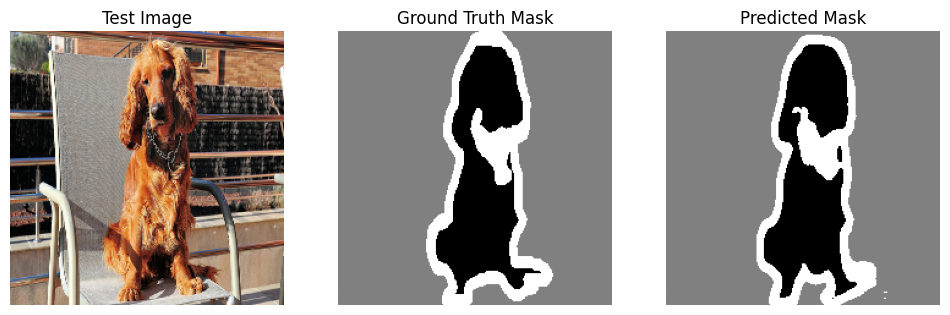

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


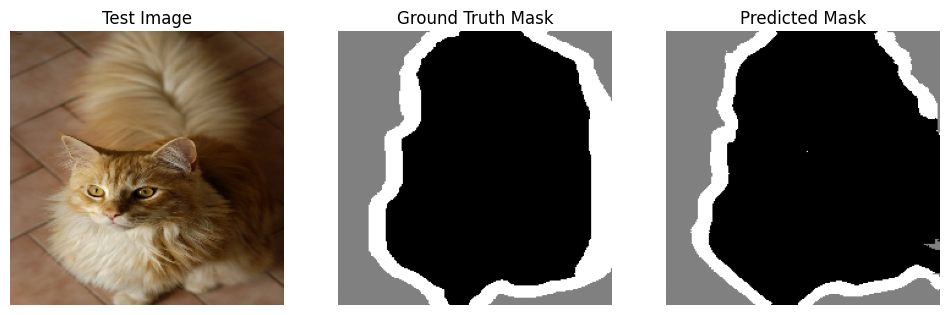

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


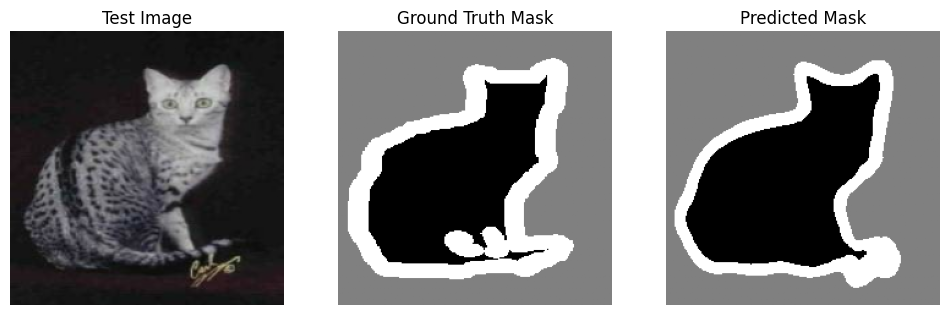

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


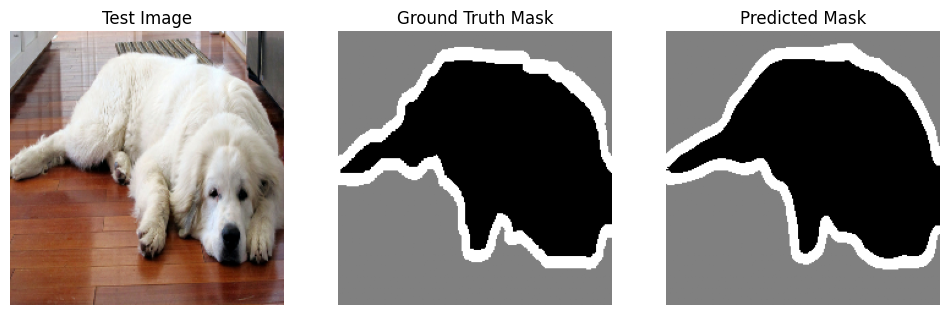

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


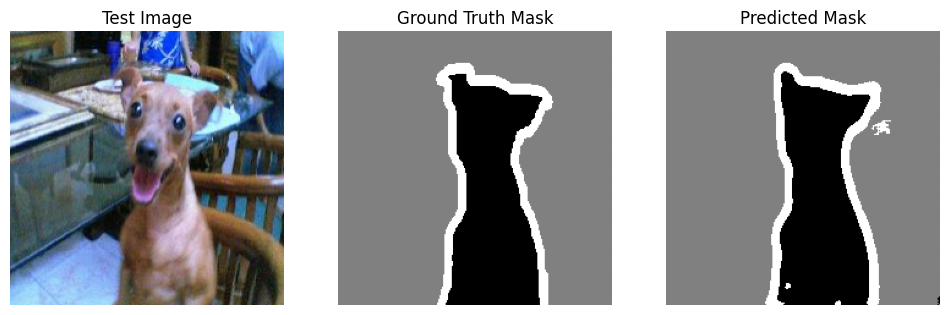

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


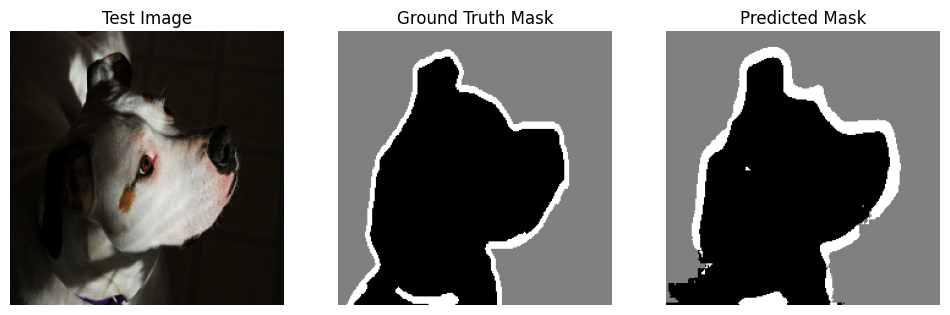

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


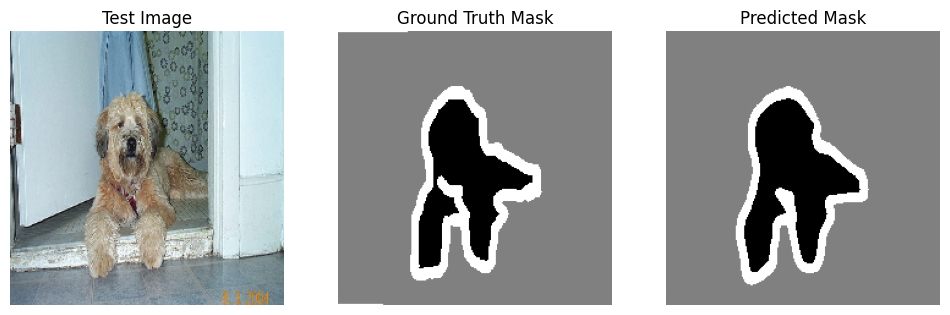

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


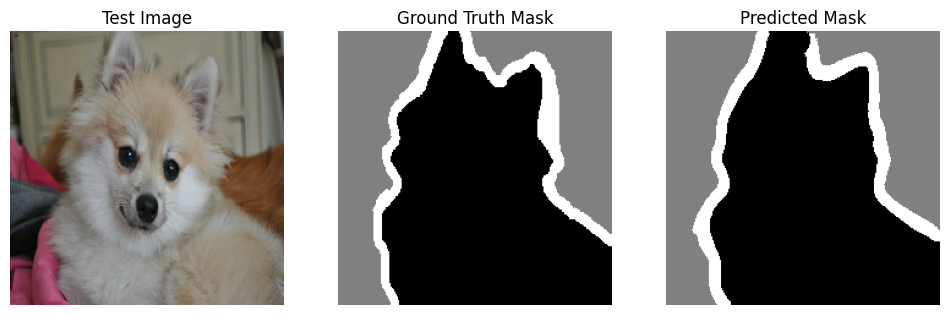

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


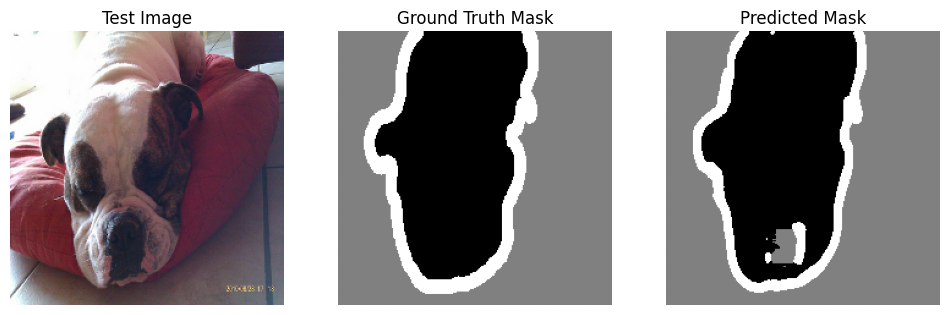

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


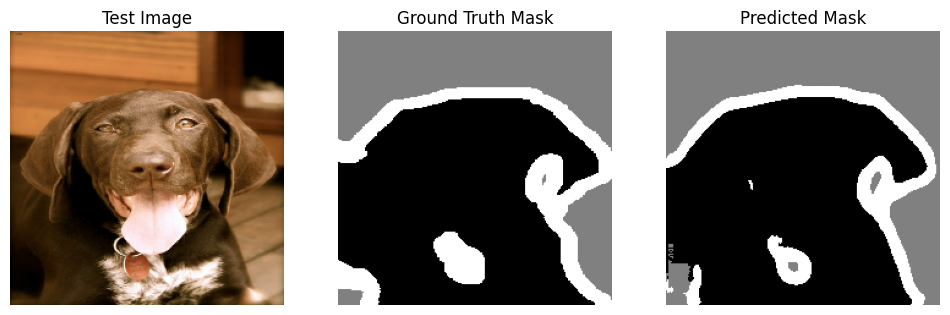

In [27]:
for images, masks in test_dataset:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1)

    for i in range(len(images)):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Test Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

In [28]:
test_imgs = image_paths[-100:]
test_masks = mask_paths[-100:]

test_dataset = tf.data.Dataset.from_tensor_slices((test_imgs, test_masks))
test_dataset = test_dataset.map(load_image_and_mask).batch(8).prefetch(tf.data.AUTOTUNE)

In [29]:
def evaluate_model_on_dataset(model, dataset):
    total_iou = 0
    total_acc = 0
    count = 0

    for images, masks in dataset:
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1)
        preds = tf.cast(preds, tf.int32)

        # IoU
        intersection = tf.reduce_sum(tf.cast(masks == preds, tf.float32))
        union = tf.cast(tf.size(masks), tf.float32)
        iou = intersection / union

        # Accuracy
        acc = tf.reduce_mean(tf.cast(masks == preds, tf.float32))

        total_iou += iou.numpy()
        total_acc += acc.numpy()
        count += 1

    mean_iou = total_iou / count
    mean_acc = total_acc / count

    print(f"Mean IoU on test set: {mean_iou:.4f}")
    print(f"Mean Pixel Accuracy on test set: {mean_acc:.4f}")

In [30]:
evaluate_model_on_dataset(model, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Mean IoU on test set: 0.9406
Mean Pixel Accuracy on test set: 0.9406
